TS-Data path: /data/akristo/timeseries-similarity/data
Selected dataset: TwoPatterns
Dataset shape: Train: (1000, 128, 1), Test: (4000, 128, 1)


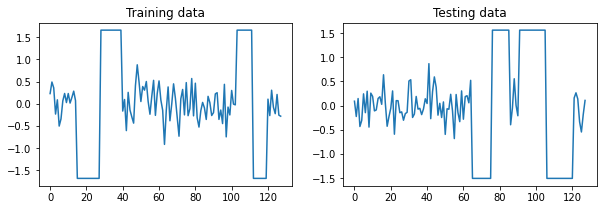

In [1]:
import sys
import py_ts_data

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime
from itertools import tee
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers,losses
from tensorflow.signal import fft, ifft
from tensorflow.math import conj
import tensorflow.keras.backend as K
import dRNN

# Util functions
def min_max(data, feature_range=(0, 1)):
    """
    implements min-max scaler
    """
    min_v = feature_range[0]
    max_v = feature_range[1]
    max_vals = data.max(axis=1)[:, None]
    min_vals = data.min(axis=1)[:, None]
    X_std = (data - min_vals) / (max_vals - min_vals)
    return X_std * (max_v - min_v) + min_v

def normalize(data):
    """
    Z-normalize data with shape (x, y, z)
    x = # of timeseries
    y = len of each timeseries
    z = vars in each timeseres
    
    s.t. each array in [., :, .] (i.e. each timeseries variable)
    is zero-mean and unit stddev
    """
    sz, l, d = data.shape
    means = np.broadcast_to(np.mean(data, axis=1)[:, None], (sz, l, d))
    stddev = np.broadcast_to(np.std(data, axis=1)[:, None], (sz, l, d)) 
    return (data - means)/stddev

# Util: Pair creator
def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a,b)


def SBD(X, Y):
    # Takes two tensors X, Y, both with the same shape (batch_sz, ts_length)
    # Returns a tensor Z with shape (batch_sz,), where Z[i] = sbd(X[i], Y[i])

    assert len(X.shape) == 2
    assert len(Y.shape) == 2

    l = X.shape[1]
    den = tf.reshape(tf.cast(tf.norm(X, axis=1) * tf.norm(Y, axis=1), dtype=tf.float64), (-1, 1))
    den = tf.where(den != 0, den, float('inf'))
    X = tf.cast(X, dtype=tf.complex64)
    Y = tf.cast(Y, dtype=tf.complex64)
    cc = ifft(fft(X) * conj(fft(Y)))
    cc = tf.concat([cc[:, -(l-1):], cc[:, :l]], axis=1)
    ncc = tf.cast(tf.math.real(cc), dtype=tf.float64)/den
    Z = 1 - tf.reduce_max(ncc, axis=1)
    return Z

# Define the SBD loss
class SBDLoss(losses.Loss):
    """ Computes the Shape-based distances between two univariate timeseries """

    def __init__(self, name='sbd'):
        super(SBDLoss, self).__init__(name=name)

    def call(self, X, Y):
        return SBD(X, Y)

    

# Read in the data
DATASET_NAME = "TwoPatterns"
X_train, y_train, X_test, y_test, info = py_ts_data.load_data(DATASET_NAME, variables_as_channels=True)
print("Selected dataset: {}".format(DATASET_NAME))
print("Dataset shape: Train: {}, Test: {}".format(X_train.shape, X_test.shape))

# Generate a preview of the dataset
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(X_train[0])
axs[0].set_title("Training data")
X_train = min_max(X_train, feature_range=(-1, 1))
axs[1].plot(X_test[0])
axs[1].set_title("Testing data")
X_test = min_max(X_test, feature_range=(-1, 1))
plt.show()


Training...
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
DONE


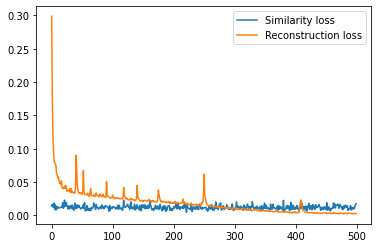

In [2]:
class Encoder(tf.keras.Model):

    def __init__(self, opts):
        super(Encoder, self).__init__()
        self.hidden_units = opts['encoder_hidden_units']
        self.dilations = opts['dilations']
        self.input_shape_ = opts['input_shape']
        self.code_size = opts['code_size']
        assert (len(self.hidden_units) == len(self.dilations))
        self.cell_fw_list = [tf.keras.layers.GRUCell(units, dtype=tf.float64) for units in self.hidden_units]
        self.drnn1 = dRNN.multi_dRNN_with_dilations(self.cell_fw_list, self.dilations)
        self.flatten = tf.keras.layers.Flatten()
        self.feed_forward_layer_1 = tf.keras.layers.Dense(self.code_size, activation="tanh")
        self.output_len = self.input_shape_[0]
        self.output_channels = self.hidden_units[-1]
        self.last_kernel_shape = (self.output_len, self.output_channels)

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float64)
        outputs_fw, states_fw = self.drnn1(inputs)
        x = self.flatten(outputs_fw)
        x = self.feed_forward_layer_1(x)
        return x

class Decoder(tf.keras.Model):

    def __init__(self, opts):
        super(Decoder, self).__init__()

        self.hidden_units = opts['encoder_hidden_units']
        self.dilations = opts['dilations']
        self.last_kernel_shape = opts['last_kernel_shape']

        flat_len = self.last_kernel_shape[0] * self.last_kernel_shape[1]
        self.expand = tf.keras.layers.Dense(flat_len)
        self.reshape = tf.keras.layers.Reshape(self.last_kernel_shape)
        self.cell_fw_list = [tf.keras.layers.GRUCell(units, dtype=tf.float64) for units in self.hidden_units]
        self.drnn1 = dRNN.multi_dRNN_with_dilations(self.cell_fw_list, self.dilations)

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float64)
        x = self.expand(inputs)
        x = self.reshape(x)
        outputs_fw, states_fw = self.drnn1(x)
        return outputs_fw


# Define the model
class AutoEncoder():
    def __init__(self, **kwargs):
        
        input_shape = kwargs["input_shape"]
        code_size = kwargs["code_size"]
        filters = kwargs["filters"]
        kernel_sizes = kwargs["kernel_sizes"]

        config_dtcr = {}
        config_dtcr['encoder_hidden_units'] = filters
        config_dtcr['dilations'] = [1, 4, 16]
        config_dtcr['input_shape'] = input_shape
        config_dtcr['code_size'] = code_size

        self.first_encoder = Encoder(opts=config_dtcr)
        self.second_encoder = Encoder(opts=config_dtcr)

        config_dtcr['encoder_hidden_units'] = list(config_dtcr['encoder_hidden_units'][:len(config_dtcr['encoder_hidden_units'])-1])
        config_dtcr['encoder_hidden_units'].append(input_shape[1])
        config_dtcr['last_kernel_shape'] = self.first_encoder.last_kernel_shape
        self.decoder = Decoder(opts=config_dtcr)


# Define the optimizer
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)

# Define the training function
@tf.function
def train_step(first_input, second_input, model, alpha=1, SBD_normalization_factor=0.1):
    with tf.GradientTape() as tape:

        # Execute the model
        first_code = model.first_encoder(first_input)
        second_code = model.second_encoder(second_input)
        first_output = model.decoder(first_code)

        # Calculate the Euclidean distance of the codes
        codes_distance = SBD_normalization_factor * tf.norm(first_code - second_code, ord='euclidean', axis=1)

        # Calculate the SBD of inputs
        inputs_distance = SBD(tf.squeeze(first_input, axis=2), tf.squeeze(second_input, axis=2))

        # Calculate the loss between the codes and inputs
        similarity_loss = alpha * (losses.MeanSquaredError()(codes_distance, inputs_distance))

        # Calculate the loss between the first input and the output
        reconstruction_loss = tf.keras.losses.MeanSquaredError()(first_input, first_output)

        # Calculate the total loss based on the weights
        total_loss = similarity_loss + reconstruction_loss

    trainables = model.first_encoder.trainable_variables + model.second_encoder.trainable_variables + model.decoder.trainable_variables 
    gradients = tape.gradient([similarity_loss, reconstruction_loss], trainables)
    optimizer.apply_gradients(zip(gradients, trainables))
    return similarity_loss, reconstruction_loss 

# Training
EPOCHS = 500
BATCH = 50
SHUFFLE_BUFFER = 100
K = len(set(y_train))

kwargs = {
    "input_shape": (X_train.shape[1],X_train.shape[2]),
    "filters": [32, 64, 128],
    "kernel_sizes": [5, 5, 5],
    "code_size": 16,
}

ae = AutoEncoder(**kwargs)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER).batch(BATCH)

similarity_loss_history = []
reconstruction_loss_history = []

print("Training...")

for epoch in range(EPOCHS):
    total_similarity_loss = 0
    total_reconstruction_loss = 0
    for (first_input, _), (second_input, _) in pairwise(train_dataset):
        similarity_loss, reconstruction_loss = train_step(first_input, second_input, ae)
    total_similarity_loss += similarity_loss
    total_reconstruction_loss += reconstruction_loss
    similarity_loss_history.append(total_similarity_loss)
    reconstruction_loss_history.append(total_reconstruction_loss)
    
plt.plot(similarity_loss_history, label="Similarity loss")
plt.plot(reconstruction_loss_history, label="Reconstruction loss")
plt.legend()

print("DONE")


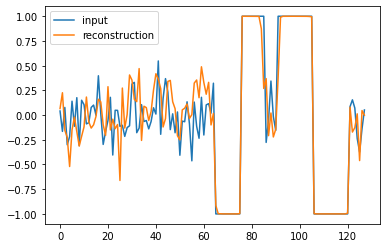

Mean L2 reconstruction loss: 3.6259561150541386
Mean SBD reconstruction loss: 0.12694529846182026


In [3]:

# Testing reconstruction
code_test = ae.first_encoder(X_test)
decoded_test = ae.decoder(code_test)

plt.plot(X_test[0], label="input")
plt.plot(decoded_test[0], label="reconstruction")
plt.legend()
plt.show()

l2_losses = []
for ground, predict in zip(X_test, decoded_test):
    l2_losses.append(np.linalg.norm(ground - predict))
print("Mean L2 reconstruction loss: {}".format(np.array(l2_losses).mean()))

sbd_losses = []
for ground, predict in zip(X_test, decoded_test):
    sbd_losses.append(SBD(tf.reshape(ground, shape=(1, -1)), tf.reshape(predict, shape=(1, -1))))
print("Mean SBD reconstruction loss: {}".format(np.array(sbd_losses).mean()))

In [4]:

# Testing L2 similarity
from sklearn.neighbors import NearestNeighbors

def nn_l2_dist(x, y):
    """
    Sample distance metric, here, using only Euclidean distance
    """
    return np.linalg.norm(x-y)

# X_test = tf.squeeze(X_test)
X_test = np.squeeze(X_test, axis=2)
baseline_nn = NearestNeighbors(n_neighbors=10, metric=nn_l2_dist).fit(X_test)
code_nn = NearestNeighbors(n_neighbors=10).fit(code_test)

# For each item in the test data, find its 11 nearest neighbors in that dataset (the nn is itself)
baseline_11nn = baseline_nn.kneighbors(X_test, 11, return_distance=False)
code_11nn     = code_nn.kneighbors(code_test, 11, return_distance=False)

# On average, how many common items are in the 10nn?
result = []
for b, c in zip(baseline_11nn, code_11nn):
    # remove the first nn (itself)
    b = set(b[1:])
    c = set(c[1:])
    result.append(len(b.intersection(c)))
print("Mean L2 cluster size: {}".format(np.array(result).mean()))

Mean L2 cluster size: 6.6255


In [6]:
# Save model
ae.first_encoder.save('sample_model/{}/encoder'.format(DATASET_NAME))
ae.decoder.save('sample_model/{}/decoder'.format(DATASET_NAME))

INFO:tensorflow:Assets written to: sample_model/TwoPatterns/encoder/assets
INFO:tensorflow:Assets written to: sample_model/TwoPatterns/decoder/assets
